In [ ]:
#General libraries
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import os
import numpy as np

from tensorflow.keras import layers
from sklearn.metrics import classification_report,confusion_matrix

#Skimage
import skimage.io as io
from skimage.transform import  rescale,resize
from skimage import exposure
from skimage.util import img_as_uint,img_as_ubyte
from skimage.color import rgb2gray

#Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam


#Bayesian Optimization
!pip install bayesian-optimization
!pip install gpy
!pip install gpyopt
import GPy, GPyOpt

%matplotlib inline


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 959.4/959.4 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gpy: filename=GPy-1.10.0-cp310-cp310-linux_x86_64.whl size=3420831 sha256=8f3bbd8115ad4b39c81d4a98697c9dc4d10db24eff7a3f08499e29740e47506e
  Stored in directory: /root/.cache/pip/wheels/27/bd/9f/82ab4216eae088cba864ca0dc1d75699bd4bf6823790fb2f77
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102543 sha256=3f2306e967459d901fdc01bd945168b3858b5ed0da40edc85e3eb8accbf836f7
  Stored in directory: /root/.cache/pip/wheels/d2/ef/9c/da9ceef7d0ff5287c24365844fc394852c2b79ac3fcf33bf8b
Successfully built gpy paramz
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gpyopt: filename=GPyOpt-1.2.6-py3-none-any.whl size=83588 sha

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
labels = ['Covid', 'Normal','Pneumonia']
img_size = 224
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join('/content/drive/MyDrive/Đồ án cơ sở/DataSet/TrainingSet', label) #YOUR DATA PATH
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = io.imread(os.path.join(path, img))
                #img_gray = rgb2gray(img_arr)
                data.append([img_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)


In [ ]:
labels = ['Covid', 'Normal','Pneumonia']
img_size = 224
def get_dataval(data_dir):
    data = []
    for label in labels:
        path = os.path.join('/content/drive/MyDrive/Đồ án cơ sở/DataSet/ValidationSet', label) #YOUR DATA PATH
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = io.imread(os.path.join(path, img))
                #img_gray = rgb2gray(img_arr)
                data.append([img_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)


In [ ]:
labels = ['Covid', 'Normal','Pneumonia']
img_size = 224  #Por definir
def get_datatest(data_dir):
    data = []
    for label in labels:
        path = os.path.join('/content/drive/MyDrive/Đồ án cơ sở/DataSet/TestSet', label) #YOUR DATA PATH
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = io.imread(os.path.join(path, img))
                data.append([img_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
train= get_data('/content/drive/MyDrive/Đồ án cơ sở/DataSet/TrainingSet')

In [ ]:
val= get_dataval('/content/drive/MyDrive/Đồ án cơ sở/DataSet/ValidationSet')

In [ ]:
test= get_datatest('/content/drive/MyDrive/Đồ án cơ sở/DataSet/TestSet')

Found 294 files belonging to 3 classes.


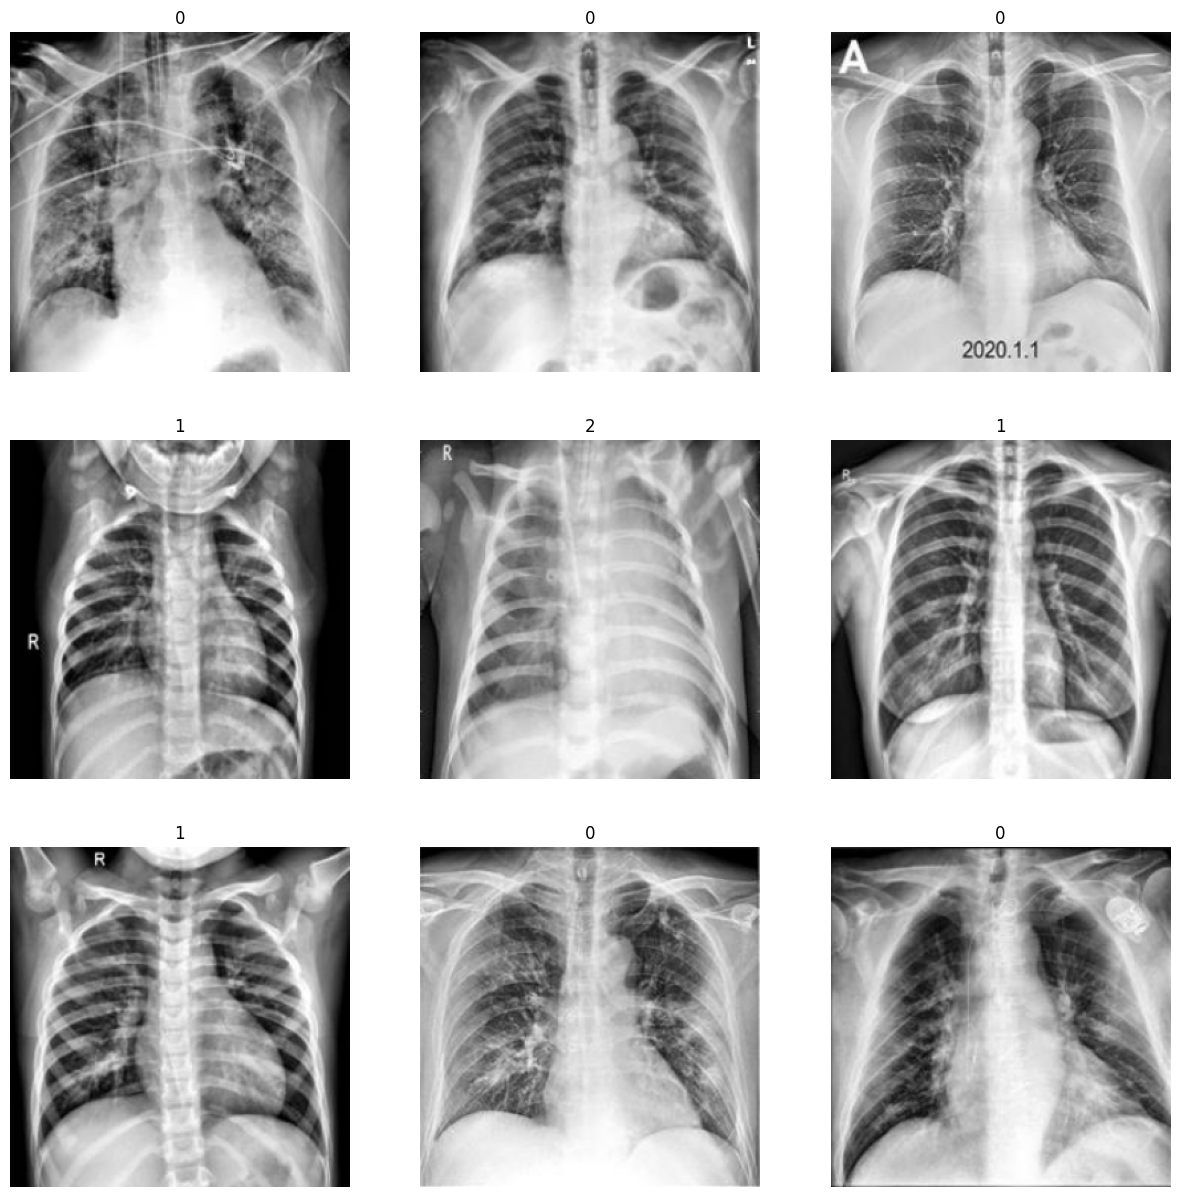

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Đồ án cơ sở/DataSet/TrainingSet")
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

#0 -> Covid
#1 -> Normal
#2 -> Pneumonia

In [ ]:
# plt.figure(figsize = (7,7))
# plt.imshow(train[250][0],cmap=plt.cm)
# plt.figtext(.5,.9,'Covid (class = 0)', fontsize=40, ha='center')

In [ ]:

x_train = [] #Samples
y_train = [] #Labels

x_val = []  #Samples
y_val = [] #Labels

x_test = []  #Samples
y_test = [] #Labels


#TRAINING SET SAMPLES AND LABELS CREATON
for feature, label in train:
  x_train.append(feature)
  y_train.append(label)


#VALIDATION SET SAMPLES AND LABELS CREATION
for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

#TEST SET SAMPLES AND LABELS CREATION
for feature, label in test:
  x_test.append(feature)
  y_test.append(label)


# NORMALIZATION
x_train_normalized = np.array(x_train)/ 255
x_val = np.array(x_val) / 255
x_test= np.array(x_test)/255

#LABELS OF EACH SET
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test= np.array(y_test)

In [ ]:

from sklearn.decomposition import PCA
from sklearn.decomposition import PCA as RandomizedPCA

shape = x_train_normalized.shape
img_r = x_train_normalized.reshape((shape[0], shape[1] * shape[2])) #input 3D -> 2D reshape
X = img_r
pca = RandomizedPCA(150,copy=True, whiten=False, svd_solver='full', tol=0.0, iterated_power='auto', random_state=None)
pca.fit(X)

PCA(n_components=150, svd_solver='full')

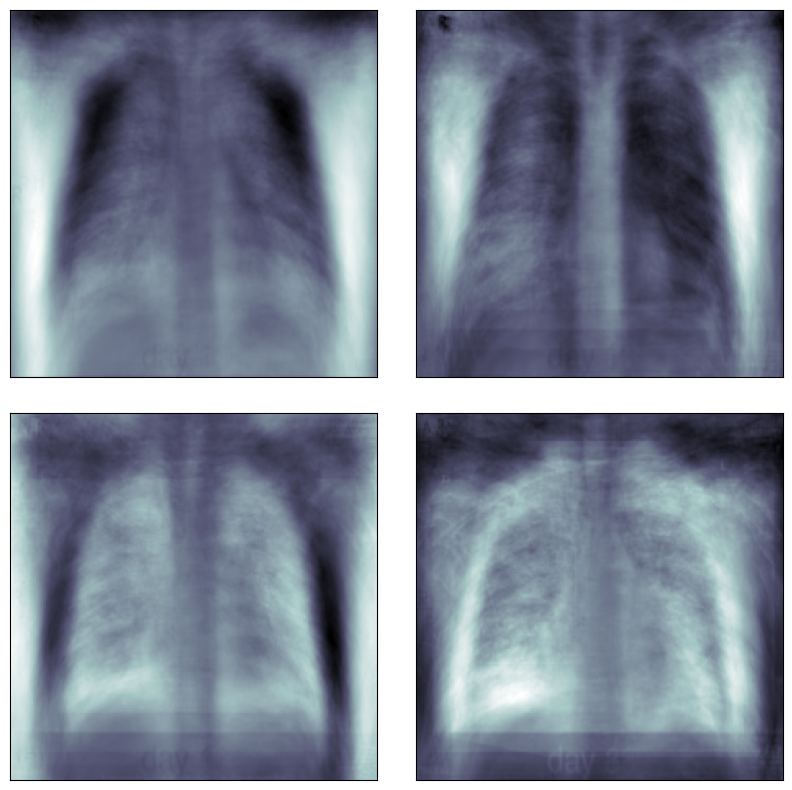

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10,10),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(224, 224), cmap='bone')

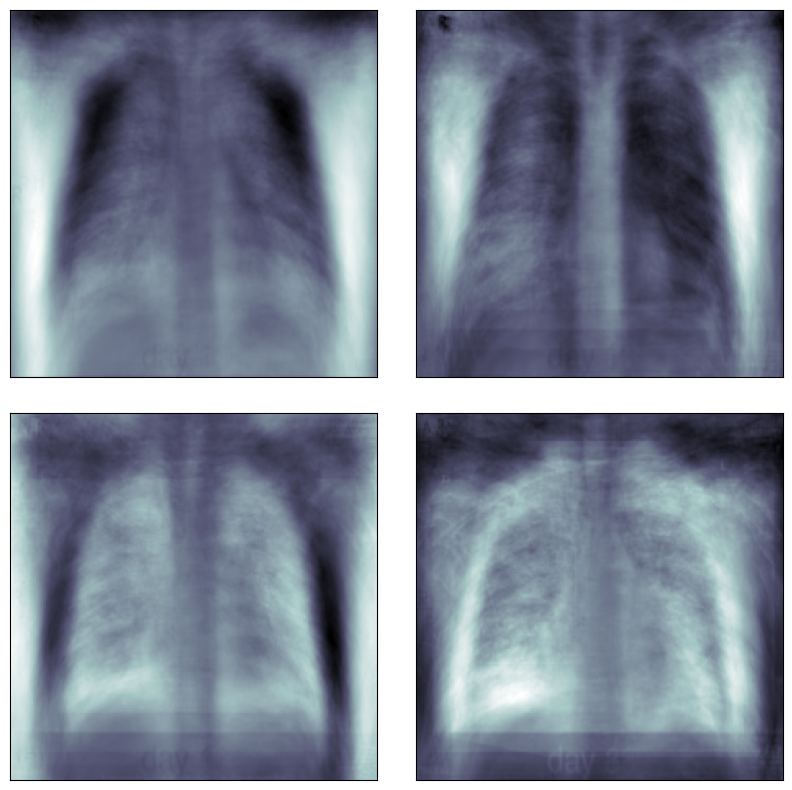

In [ ]:

#======================
#CXR EIGENVECTORS PLOT
#======================
fig, axes = plt.subplots(2, 2, figsize=(10,10),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(224, 224), cmap='bone')

(array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 [Text(0, 0.1, '0.1'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.30000000000000004, '0.3'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.5, '0.5'),
  Text(0, 0.6, '0.6'),
  Text(0, 0.7000000000000001, '0.7'),
  Text(0, 0.8, '0.8'),
  Text(0, 0.9, '0.9'),
  Text(0, 1.0, '1.0')])

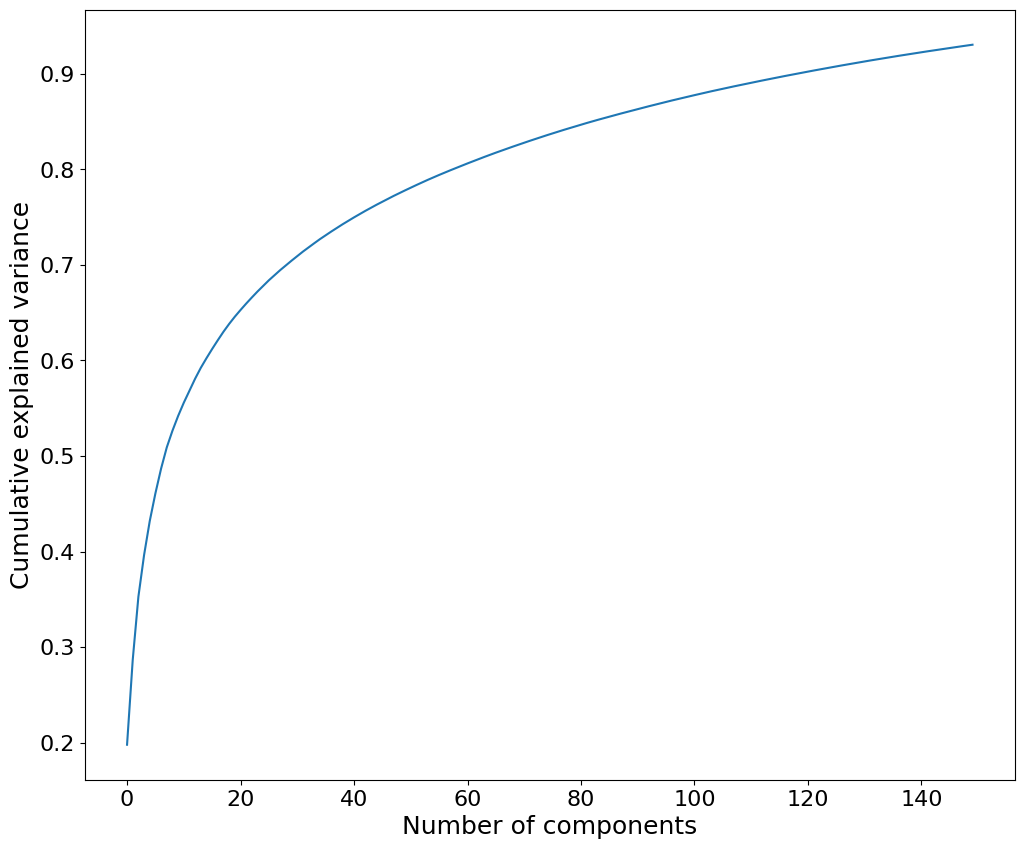

In [ ]:
plt.figure(figsize=(12, 10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components',fontsize=18)
plt.ylabel('Cumulative explained variance',fontsize=18);
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

In [ ]:

#================================
#COMPUTE THE NUMBER OF COMPONENTS
#================================

pca = RandomizedPCA(0.95).fit(X) #95%
components = pca.transform(X)
projected = pca.inverse_transform(components)

Text(0, 0.5, '150-dim\nreconstruction')

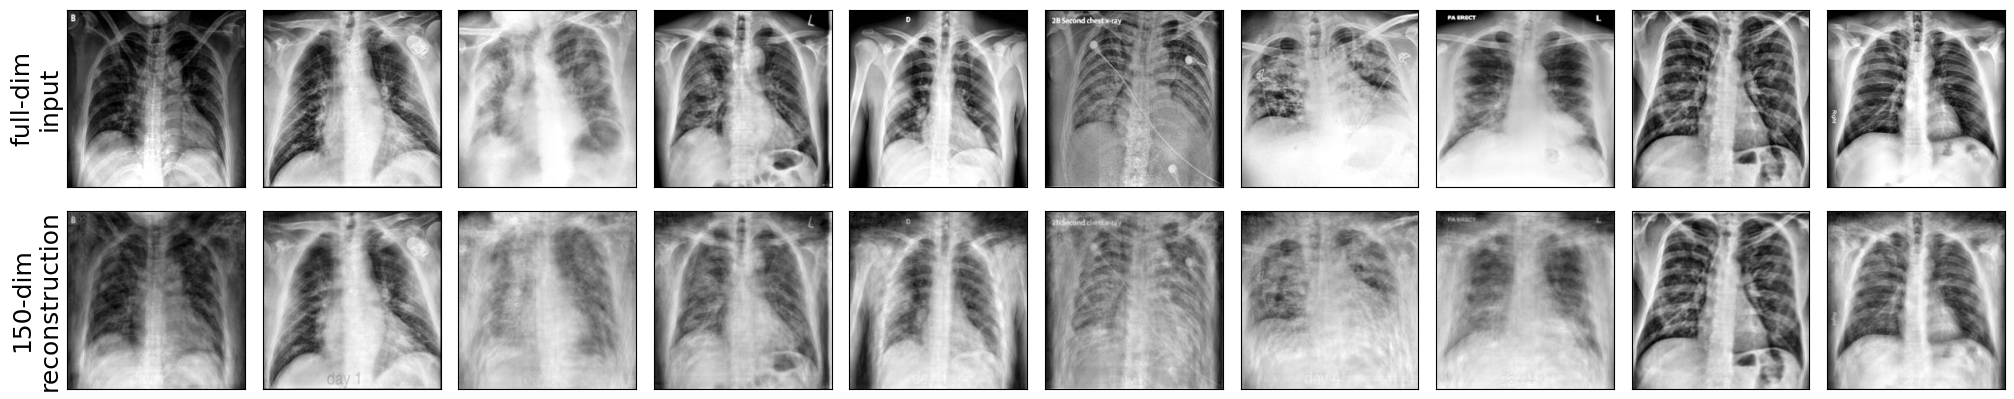

In [ ]:

#=======================================
#DIMENSIONAL RECONSTRUCTED OUTPUT PLOT
#=======================================
fig, ax = plt.subplots(2, 10, figsize=(25, 5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(X[i].reshape(224,224), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(224, 224), cmap='binary_r')

ax[0, 0].set_ylabel('full-dim\ninput', fontsize=18)
ax[1, 0].set_ylabel('150-dim\nreconstruction',fontsize=18)

In [ ]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from keras.layers import Activation, Dropout, BatchNormalization, Dense
from keras.metrics import categorical_crossentropy
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import pandas as pds
import random
import time

Data augmentation

In [ ]:
#===========================
#TRAINING AND TESTING SHAPES
#===========================

x_train= np.reshape(x_train_normalized, (294, 224, 224,1))
x_test= np.reshape(x_test, (63, 224, 224,1))

#Training
print('x_train set shape>>>>',x_train.shape)
print('y_train set shape>>>>',y_train.shape)

#Testing
print('x_test set shape>>>>',x_test.shape)
print('y_test set shape>>>>',y_test.shape)

x_train set shape>>>> (294, 224, 224, 1)
y_train set shape>>>> (294,)
x_test set shape>>>> (63, 224, 224, 1)
y_test set shape>>>> (63,)


In [ ]:
#==========================================================
#DATA AUGMENTATION OPERATIONS WITH OPTIMAL HYPERPARAMETERS
#==========================================================
datagen = ImageDataGenerator(
        rotation_range = 190.7809510335889,
        zoom_range = 0.347686203808678,
        width_shift_range= 0.07712976589332243,
        height_shift_range= -0.04710934652942281,
        horizontal_flip = True,
        vertical_flip=False)

dgf=datagen.fit(x_train)

In [ ]:
#### MODEL OPTIMIZED HYPERPARAMETERS #####
adam_lr= 0.0002587553425186625           #
batch_size=3                             #
epochs=300                               #
##########################################


def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size= 1,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size= 3,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out


def create_res_net():

    inputs = Input(shape=(224,224,1))
    num_filters = 64

    t = BatchNormalization()(inputs)
    t = Conv2D(kernel_size=1,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)

    num_blocks_list = [2, 5, 5, 2]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
        num_filters *= 2

    t = AveragePooling2D(4)(t)
    t = Flatten()(t)
    outputs = Dense(3, activation='softmax')(t)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=adam_lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
#=========
#ResNet
#========
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
import datetime
import time
inicio = time.time()

(x_train, y_train), (x_test, y_test) = (x_train,y_train),(x_test, y_test)

model = create_res_net()  #ResNet
model.summary()

timestr = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
name = 'RESNET'+timestr



#######################################MODEL CHECKPOINTS ###########################################################
checkpoint_path = "/content/Weigths"+name+"/_weights.{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path)
os.system('mkdir {}'.format(checkpoint_dir))

cp_callback = ModelCheckpoint(
    filepath= checkpoint_path ,save_weights_only=True, monitor='val_loss',mode='min',
     verbose=0, save_best_only=True  # will show you nothing (silent), solo se almacenan los mejores resultados
)
#####################################################################################################################


tensorboard_callback = TensorBoard(
    log_dir='tensorboard_logs/'+name,
    histogram_freq=1
)


early_stopping = EarlyStopping(patience=200, verbose=1,restore_best_weights=True)
history = model.fit(datagen.flow(
    x=x_train,
    y=y_train, batch_size=batch_size),
    epochs=epochs,
    verbose=1,
    validation_data=(x_test, y_test),

    callbacks=[early_stopping, cp_callback, tensorboard_callback]
)
fin = time.time()
print('Compilation time in seconds >>>> ', fin-inicio)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 batch_normalization (Batch  (None, 224, 224, 1)          4         ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 64)         128       ['batch_normalization[0][0]'] 
                                                                                                  
 re_lu (ReLU)                (None, 224, 224, 64)         0         ['conv2d[0][0]']          

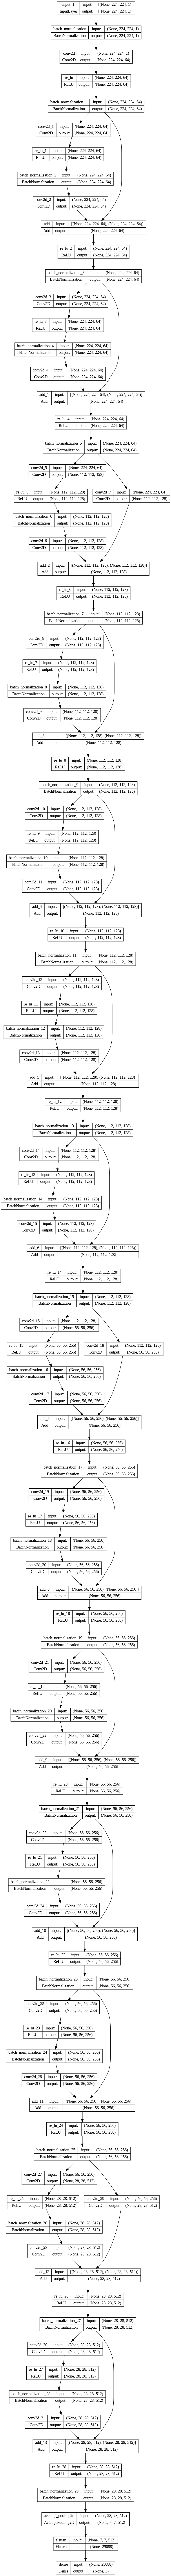

In [ ]:
#==============
#ResNet Summary
#==============
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    #show_2type=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

In [ ]:
#==========================
#LOADING BEST MODEL WEIGTHS
#==========================
#bw_path='/content/WeigthsRESNET20210510-204850/_weights.207-0.19.hdf5'
# model.load_weights(bw_path)


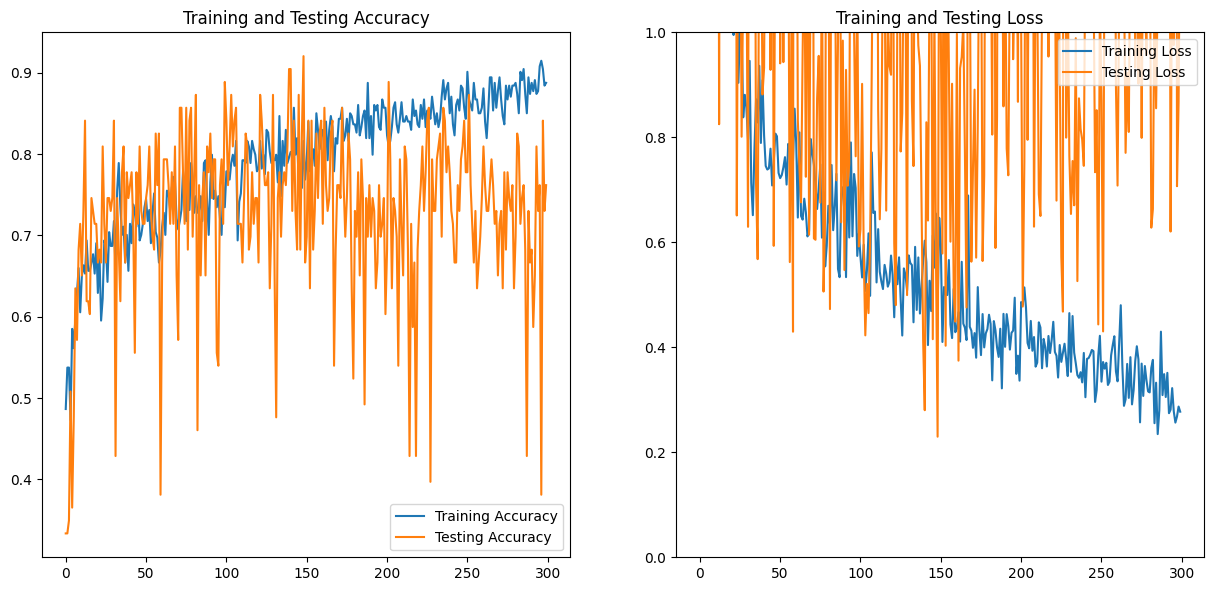

In [ ]:
#==============================
#TRAINING ANS TESTING ACCURACY
#==============================

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(300)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Testing Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Testing Accuracy')


#==============================
#TRAINING ANS TESTING LOSS
#==============================

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Testing Loss')
plt.legend(loc='upper right')
plt.title('Training and Testing Loss')
plt.ylim([0, 1])
plt.show()

In [ ]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (22, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Testing loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Testing Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

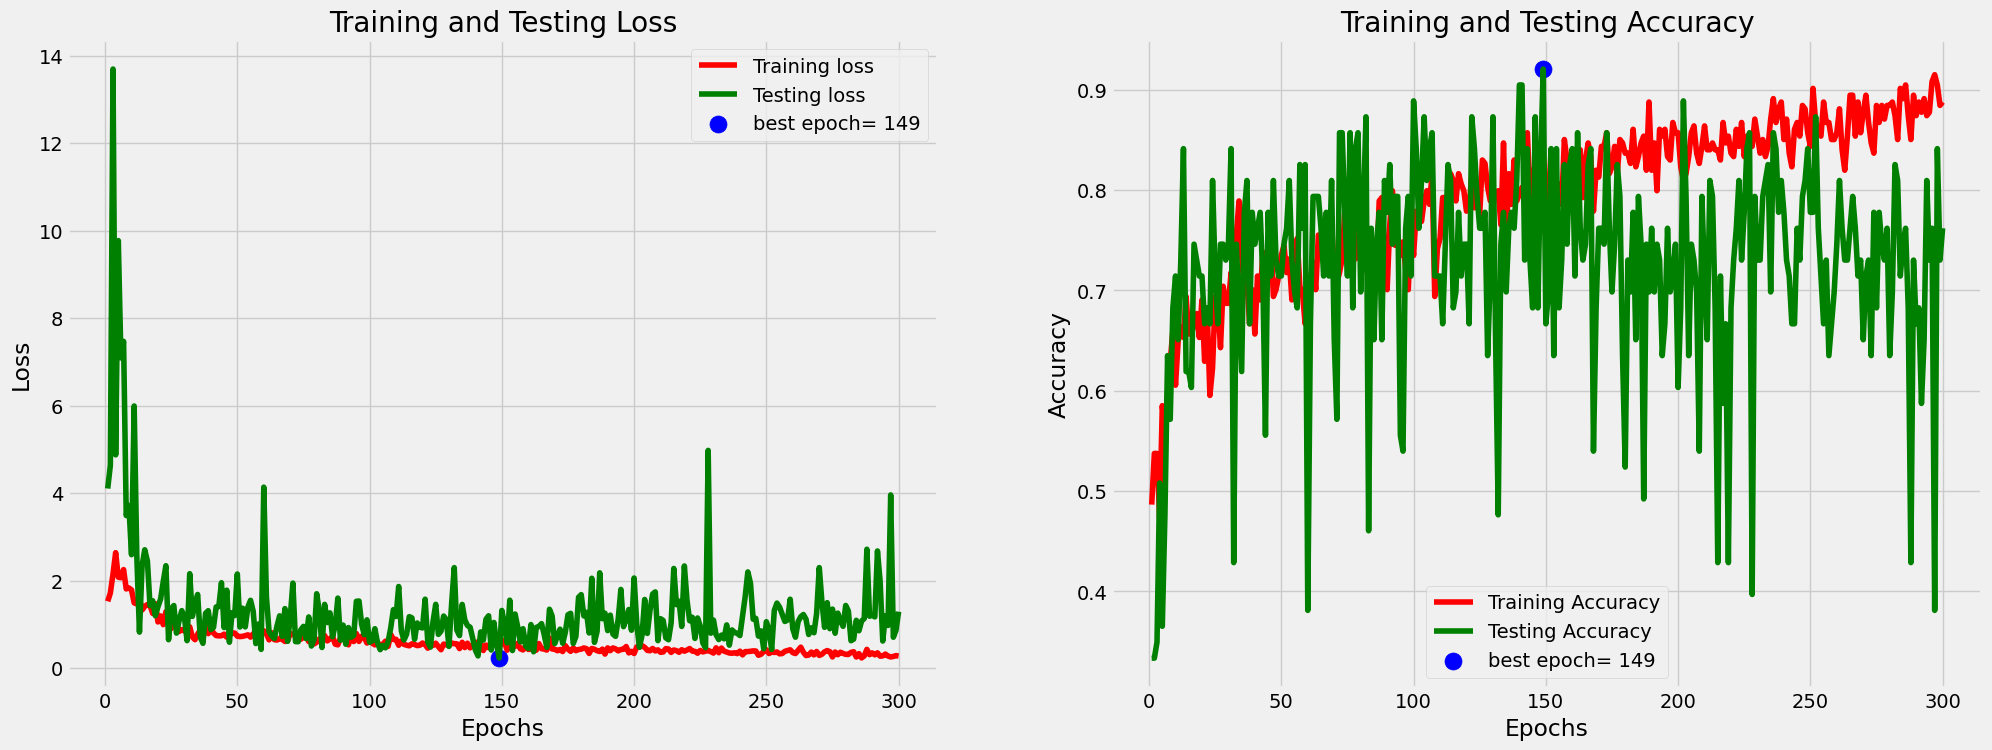

In [ ]:
plot_training(history)

In [ ]:
#==============================
#MODEL METRICS
#==============================
predict_prob=model.predict([x_test])
predict_classes=np.argmax(predict_prob,axis=1)
predictions = predict_classes.reshape(1,-1)[0]
print(classification_report(y_val, predictions, target_names = ['Covid (Class 0)','Normal (Class 1)','Pneumonia(Class 2)']))


2/2 [==============================] - 1s 458ms/step
                    precision    recall  f1-score   support

   Covid (Class 0)       0.84      1.00      0.91        21
  Normal (Class 1)       0.66      1.00      0.79        21
Pneumonia(Class 2)       1.00      0.29      0.44        21

          accuracy                           0.76        63
         macro avg       0.83      0.76      0.72        63
      weighted avg       0.83      0.76      0.72        63



In [ ]:
#==============================
#MODEL PREDICTIONS
#==============================
print(predict_prob.shape)
print(predictions)
print(y_val)

(63, 3)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 1 2 2 1 1 0 1 1 0 1 2 1 0 1 1 1 2 0 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
